# 0.0 IMPORTS

In [100]:
import pandas                                          as pd
import inflection
import math
import numpy                                           as np
import seaborn                                         as sns
import matplotlib.pyplot                               as plt
import matplotlib.gridspec                             as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

from scipy                 import stats                as ss
from geopy.distance        import geodesic
import holidays

from sklearn               import preprocessing        as pp
from imblearn              import combine              as c
from pandas_profiling      import ProfileReport
from sklearn               import model_selection      as ms
from sklearn               import ensemble             as en

from boruta                import BorutaPy
from sklearn               import metrics              as m
from scikitplot            import metrics              as mt
from sklearn               import neighbors            as nb
from sklearn               import linear_model         as lm
from sklearn               import svm

## 0.1 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_202004_raw = pd.read_csv('data/202004_tripdata.csv', low_memory=False)
df_202005_raw = pd.read_csv('data/202005_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_202004_raw, df_202005_raw] )

df_202006_raw = pd.read_csv('data/202006_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_202006_raw] )

df_202007_raw = pd.read_csv('data/202007_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_raw, df_202007_raw] )

In [5]:
df_trip_raw.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,is_equity
42910,F23686B4DB39A329,docked_bike,2020-06-28 18:54:53,2020-06-28 19:10:40,21st St & Pennsylvania Ave NW,268.0,18th St & Wyoming Ave NW,76.0,38.901539,-77.046564,38.918809,-77.041571,casual,NaN
80105,54C292C01FA062DB,docked_bike,2020-05-12 17:33:38,2020-05-12 18:01:01,Edgewood Rec Center,642.0,Edgewood Rec Center,642.0,38.924100,-77.002100,38.924100,-77.002100,casual,False
10866,669866D6622416A0,docked_bike,2020-04-26 21:25:01,2020-04-26 21:31:40,14th & Irving St NW,461.0,14th & Upshur St NW,89.0,38.928600,-77.032200,38.942500,-77.032700,member,NaN
21591,23DA164FD84DA8F2,docked_bike,2020-05-30 15:17:16,2020-05-30 15:30:39,Wisconsin Ave & O St NW,289.0,New Hampshire Ave & T St NW,131.0,38.908500,-77.063600,38.915500,-77.038200,casual,False
38140,1CABF8660DF6A193,docked_bike,2020-06-08 20:03:10,2020-06-08 22:46:36,19th & East Capitol St SE,63.0,19th & East Capitol St SE,63.0,38.889600,-76.976900,38.889600,-76.976900,casual,NaN


# 1.0 - DESCRIPTION OF DATA

In [6]:
df1 = df_trip_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns
# I like to modify the column names in order to change all of them in lower case and underline between words. At the same time, names must be self-explanatory.
# All the columns names are fine.

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'is_equity'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 666532
Number of Cols: 14


## 1.3 Data Types

In [9]:
df1.dtypes
# Observe date. It has a different data type.
# The id columns are with wrong data type also.

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
is_equity              object
dtype: object

In [10]:
df1['started_at'] = pd.to_datetime( df1['started_at'] )
df1['ended_at'] = pd.to_datetime( df1['ended_at'] )

df1['start_station_id'] = df1['start_station_id'].apply( lambda x: str(x) )
df1['end_station_id'] = df1['end_station_id'].apply( lambda x: str(x) )

In [11]:
df1.dtypes
# Everything is correct now!

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
is_equity                     object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name      3972
start_station_id           0
end_station_name        7491
end_station_id             0
start_lat                  1
start_lng                  1
end_lat                 2922
end_lng                 2922
member_casual              0
is_equity             517546
dtype: int64

## 1.5 Fillout NA

In [13]:
# When I checked the "start_station_name" and "end_station_name" which have Nan values, I realized that the "start_station_id" and "end_station_id" aldo have nan values like a string.
# For this reason, It will impossible complete station names by its station ids.
# I thought that is more important drop the columns with NaN values, instead of drop all of the rows.
# I won't lose relevant information because I already have the lat/long of these places.
df1[df1['start_station_name'].isna()==True].sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,is_equity
7644,9BEBA44D20CFC218,electric_bike,2020-07-27 17:43:41,2020-07-27 18:19:42,NaN,nan,NaN,nan,38.89,-77.11,38.87000,-77.1000,casual,NaN
79126,F0F775B05B7C3A9F,electric_bike,2020-07-31 21:34:36,2020-07-31 22:05:30,NaN,nan,Lincoln Park / 13th & East Capitol St NE,140.0,38.87,-77.00,38.89047,-76.9884,member,NaN
6553,AE604473A77BE621,electric_bike,2020-07-24 17:38:30,2020-07-24 18:52:35,NaN,nan,NaN,nan,38.91,-77.03,38.91000,-77.0300,casual,NaN
1355,70C98D6A5539F61F,electric_bike,2020-07-26 21:35:33,2020-07-26 21:37:47,NaN,nan,NaN,nan,38.90,-77.06,38.90000,-77.0600,casual,NaN
990,EC780910D691953E,electric_bike,2020-07-27 20:35:23,2020-07-27 20:48:02,NaN,nan,NaN,nan,38.88,-77.01,38.90000,-77.0200,casual,NaN


In [14]:
# I tried to complete the "start_lat" and "star_lng" finding other row which had the same station name with its lat/lng filled, but there wasn't.
# Because of this, I have to drop the entire row.
df1.dropna( subset=['start_lat', 'start_lng'], inplace=True )

In [15]:
#  When I checked the "en_lat" and "end_lng" which have Nan values, I realized that the "end_station_name" and "end_station_id" aldo have nan values.
# For this reason, It will impossible complete lat/lng by its station names or ids.
# As I will use the lat/lng variables in my project, in this case I will drop all of the rows instead of only the both columns.
# This drop will make me lose just 0,6% of my dataset.
df1[(df1['end_lat'].isna()==True) | (df1['end_lng']==True)].sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,is_equity
139622,862B674E561ED2BC,docked_bike,2020-07-29 15:28:44,2020-07-30 16:28:33,Benning Rd & East Capitol St NE / Benning Rd M...,42.0,NaN,nan,38.889935,-76.937230,NaN,NaN,casual,NaN
74126,6DC77D8EF4B9B64E,docked_bike,2020-05-10 14:56:04,2020-05-11 06:06:11,Ohio Dr & West Basin Dr SW / MLK & FDR Memorials,163.0,NaN,nan,38.884100,-77.046600,NaN,NaN,casual,False
181754,311403462E02BB4F,docked_bike,2020-07-01 19:17:23,2020-07-01 20:08:00,Gravelly Point,230.0,NaN,nan,38.865029,-77.039511,NaN,NaN,casual,NaN
95998,C31CA45383110849,docked_bike,2020-06-22 21:10:36,2020-06-23 01:36:05,Anacostia Ave & Benning Rd NE / River Terrace,43.0,NaN,nan,38.896544,-76.960120,NaN,NaN,casual,NaN
68602,4428C5DC9C88CB93,docked_bike,2020-04-25 13:47:38,2020-04-25 14:30:10,1st & Rhode Island Ave NW,60.0,NaN,nan,38.915400,-77.012300,NaN,NaN,member,NaN


In [16]:
df1.dropna( subset=['end_lat', 'end_lng'], inplace=True )

In [17]:
# In the "is_equity" column I have a lot of NaN values. I will drop the variable.
df1.drop( ['is_equity'], axis=1, inplace=True )

In [18]:
# As now I have sure that I won't need of these variables in any treatment of NaN values, I will drop them.
df1.drop( ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], axis=1, inplace=True )

In [19]:
df1.isna().sum()

ride_id          0
rideable_type    0
started_at       0
ended_at         0
start_lat        0
start_lng        0
end_lat          0
end_lng          0
member_casual    0
dtype: int64

In [20]:
print( 'Number of rows: {}'.format( df1.shape[0] ) ) 
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 663609
Number of columns: 9


## 1.6 Check Unbalanced Data

In [21]:
df_balanced = df1[['ride_id', 'member_casual']].groupby( 'member_casual' ).count().sort_values( 'ride_id' ).reset_index()
df_balanced['perc%'] = 100*np.round( ( df_balanced['ride_id'] / np.sum( df_balanced['ride_id'] ) ), 4 )
df_balanced

,member_casual,ride_id,perc%
0,member,329313,49.62
1,casual,334296,50.38


## 1.7 Descriptive Analysis

### 1.7.1 General

In [22]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

#### 1.7.1.1 Numerical

In [23]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,start_lat,38.782600,39.1260,0.343400,38.902493,38.902221,0.033720,0.967575,8.125335
1,start_lng,-77.368416,-76.8255,0.542916,-77.034735,-77.032300,0.038425,-2.486363,16.796304
2,end_lat,38.710000,39.1260,0.416000,38.901450,38.901755,0.033355,1.008058,8.649031
3,end_lng,-77.368416,-76.8255,0.542916,-77.034284,-77.032300,0.038148,-2.536286,17.362212


#### 1.7.1.2 Categorical

In [24]:
cat_attributes.drop( 'ride_id', axis=1 ).describe()

,rideable_type,member_casual
count,663609,663609
unique,2,2
top,docked_bike,casual
freq,647760,334296


### 1.7.2 Classes Oriented

#### 1.7.2.1 Numerical

In [25]:
aux = df1[['start_lat', 'start_lng', 'end_lat', 'end_lng']].groupby( df1['member_casual'] ).agg( 
        start_lat_min      = ('start_lat', 'min'), 
        start_lat_max      = ('start_lat', 'max'),
        start_lat_mean     = ('start_lat', 'mean'),
        start_lat_median   = ('start_lat', 'median'),
        start_lat_range    = ('start_lat', lambda x: x.max() - x.min() ),
        start_lat_skew     = ('start_lat', lambda x: x.skew() ),
        start_lat_kurtosis = ( 'start_lat', lambda x: x.kurtosis() ),
        start_lng_min    =   ('start_lng', 'min'), 
        start_lng_max    =   ('start_lng', 'max'),
        start_lng_mean   =   ('start_lng', 'mean'),
        start_lng_median =   ('start_lng', 'median'),
        start_lng_range  =   ('start_lng', lambda x: x.max() - x.min() ),
        start_lng_skew   =   ('start_lng', lambda x: x.skew() ),
        start_lng_kurtosis = ( 'start_lng', lambda x: x.kurtosis() ),
        end_lat_min    =   ('end_lat', 'min'), 
        end_lat_max    =   ('end_lat', 'max'),
        end_lat_mean   =   ('end_lat', 'mean'),
        end_lat_median =   ('end_lat', 'median'),
        end_lat_range  =   ('end_lat', lambda x: x.max() - x.min() ),
        end_lat_skew   =   ('end_lat', lambda x: x.skew() ),
        end_lat_kurtosis = ( 'end_lat', lambda x: x.kurtosis() ),
        end_lng_min    =   ('end_lng', 'min'), 
        end_lng_max    =   ('end_lng', 'max'),
        end_lng_mean   =   ('end_lng', 'mean'),
        end_lng_median =   ('end_lng', 'median'),
        end_lng_range  =   ('end_lng', lambda x: x.max() - x.min() ),
        end_lng_skew   =   ('end_lng', lambda x: x.skew() ),
        end_lng_kurtosis = ( 'end_lng', lambda x: x.kurtosis() ))

# show table
aux

,start_lat_min,start_lat_max,start_lat_mean,start_lat_median,start_lat_range,start_lat_skew,start_lat_kurtosis,start_lng_min,start_lng_max,start_lng_mean,start_lng_median,start_lng_range,start_lng_skew,start_lng_kurtosis,end_lat_min,end_lat_max,end_lat_mean,end_lat_median,end_lat_range,end_lat_skew,end_lat_kurtosis,end_lng_min,end_lng_max,end_lng_mean,end_lng_median,end_lng_range,end_lng_skew,end_lng_kurtosis
member_casual,,,,,,,,,,,,,,,,,,,,,,,,,,,,
casual,38.7826,39.126,38.900915,38.8997,0.3434,1.126300,6.997926,-77.368416,-76.8255,-77.037100,-77.032500,0.542916,-2.631705,15.954401,38.71,39.126,38.899801,38.899632,0.416,1.163256,7.419146,-77.368416,-76.825500,-77.036480,-77.032429,0.542916,-2.685636,16.490912
member,38.7826,39.126,38.904094,38.9038,0.3434,0.549374,7.891875,-77.368416,-76.8255,-77.032335,-77.032112,0.542916,-1.674970,11.396302,38.78,39.126,38.903124,38.903660,0.346,0.598027,8.535635,-77.368416,-76.825535,-77.032054,-77.032112,0.542881,-1.709699,11.788186


#### 1.7.2.2 Categorical

In [26]:
cat_attributes.drop( 'ride_id', axis=1 ).groupby( 'member_casual' ).describe()

rideable_type                            
                      count unique          top    freq
member_casual                                          
casual               334296      2  docked_bike  324590
member               329313      2  docked_bike  323170

### 1.7.3 Predictors and Class Correlation

<AxesSubplot:>

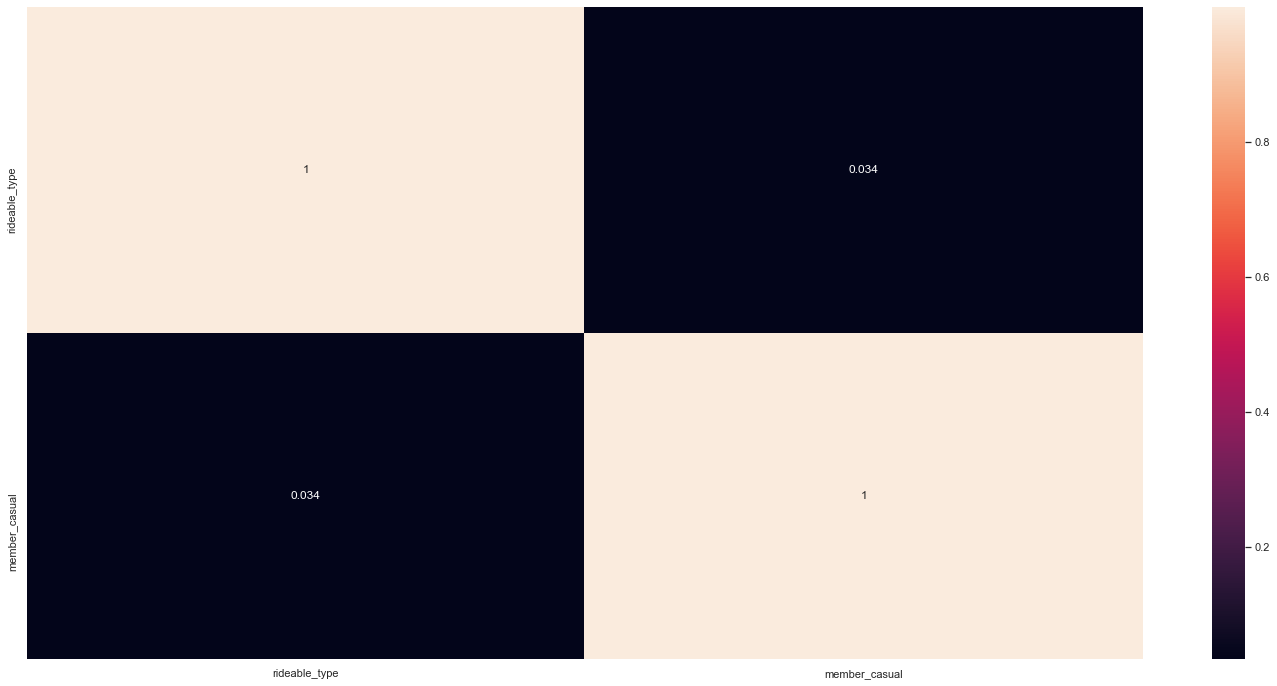

In [27]:
# list of categorical attributes
cat_attributes_list = cat_attributes.drop( 'ride_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        #print( 'Ref: {} - Feat: {}'.format( cat_attributes_list[i], cat_attributes_list[j] ) )
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation between two categorical variables
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append to a list
        corr_list.append( corr )
        
    # append the correlation list for each ref attributes
    corr_dict[ref] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 2.0 - FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

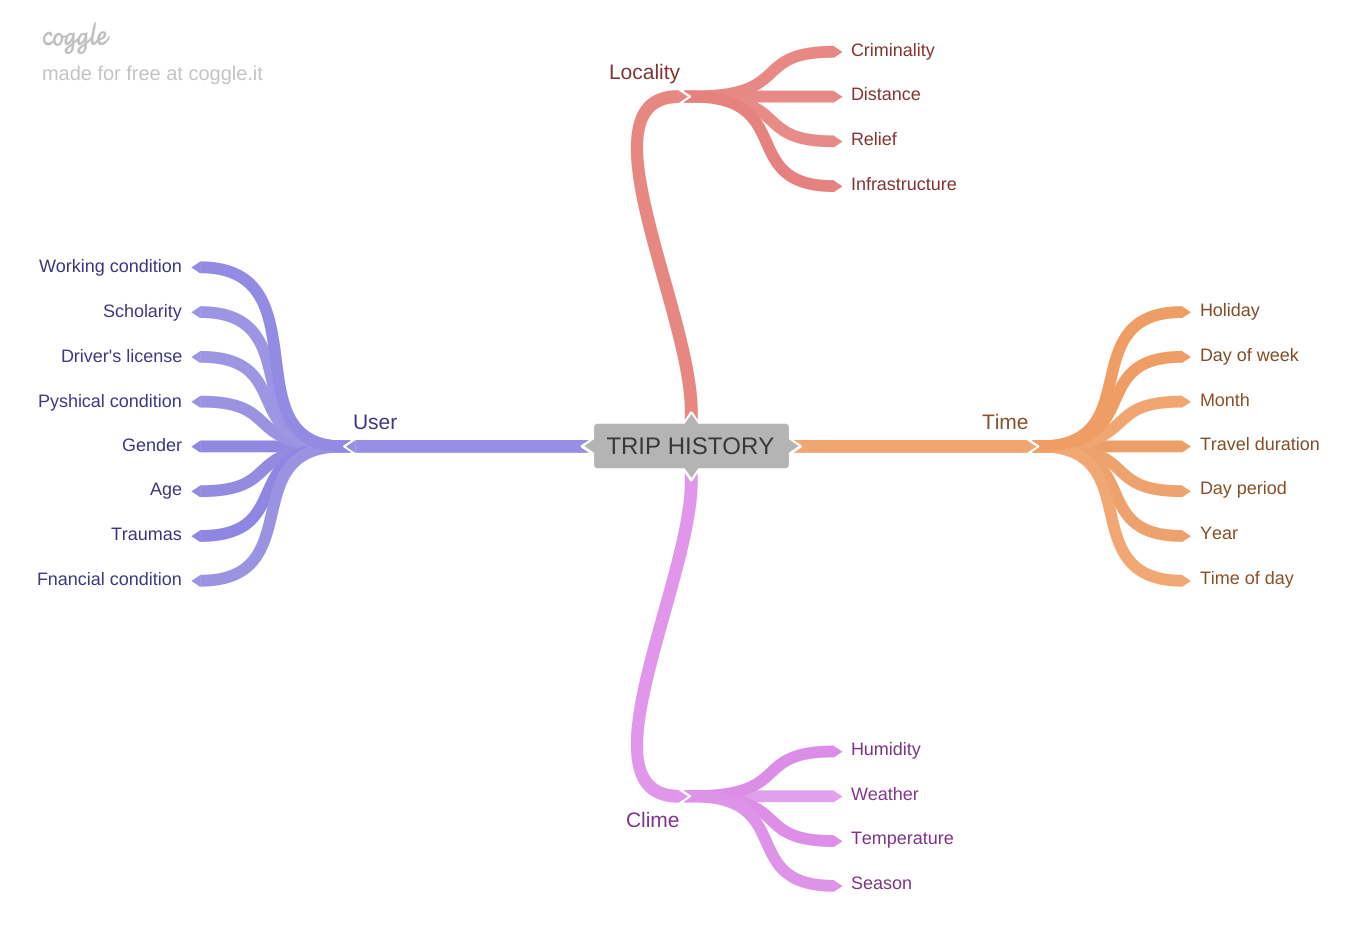

In [29]:
Image( "image/Hyphoteses_Map.png")

## 2.1 Creation of Hypotheses

### 2.1.1 Locality Hyphoteses

**1.** Casual users should be in places with higher crime.

**2.** Member users must travel greater distances.

**3.** Casual users should use the bike in steep reliefs.

**4.** Casual users should be present in greater numbers in places with more infrastructure.

### 2.1.2 Time Hyphoteses

**1.** Casual users should use more on holidays.

**2.** Member users should use more on weekdays.

**3.** Member users should use it consistently over the months.

**4.** Casual users should have longer travel times.

**5.** Member users should use more during daylight hours.

**6.** The use of casual users must have increased over the years.

**7.** Member users should use more in the early hours of the day and in the late afternoon. 

### 2.1.3 Clime Hyphoteses

**1.** Member users should use more with high humidity.

**2.** Casual users should use less during rainy seasons.

**3.** Member users should use more with high temperature.

**4.** Casual users should use more in the summer seasons.

### 2.1.4 User Hyphoteses

**1.** Member users must use more to work.

**2.** Member users should be more present in high school students.

**3.** Casual users should mostly have a driver's license.

**4.** Member users should be in better physical condition.

**5.** Casual users should be mostly men.

**6.** Member users must be mostly young.

**7.** Member users must not have trauma.

**8.** Member users must not have a good financial condition.

## 2.2 Final List of Hyphoteses

**1.** Member users must travel greater distances.

**2.** Casual users should use more on holidays.

**3.** Member users should use more on weekdays.

**4.** Member users should use it consistently over the months.

**5.** Casual users should have longer travel times.

**6.** Member users should use more during daylight hours.

**7.** The use of casual users must have increased over the years.

**8.** Member users should use more in the early hours of the day and in the late afternoon.

**9.** Casual users should use more in the summer seasons.

## 2.3 Create New Features

In [30]:
# year:
df2['year'] = df2['started_at'].dt.year

# month:
df2['month'] = df2['started_at'].dt.month

# day:
df2['day'] = df2['started_at'].dt.day

# day_of_week:
# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday
df2['day_of_week'] = df2['started_at'].dt.weekday

# holiday:
# I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
# The documentation of this librarie is in this link: https://pypi.org/project/holidays/
# Another rule that I will use is to consider the eve of the dates as a "holiday".
df2['holidays'] = df2['started_at'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

# hour_of_day:
df2['hour_of_day'] = df2['started_at'].dt.hour + df2['started_at'].dt.minute/60.0

# season:
# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).
df2['season'] = df2['started_at'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

# duration
# I will calculate the seconds between the start date and end date.
df2['duration'] = df2.apply( lambda x: (x['ended_at'] - x['started_at']).total_seconds(), axis=1 )

# distance
# I will use the "geopy" library to calculate the distance between start lat/lng and end lat/lng.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
df2['distance'] = df2.apply( lambda x: geodesic( (x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng']) ).km, axis=1 )

In [31]:
df2.sample(5).T

,142177,12158,173973,15820,40243
ride_id,255534F62AE45639,CF977448E4285801,02A4CBBD07FE4992,42B438B2BBCC9D97,746F5BC0BA0B9CEC
rideable_type,docked_bike,docked_bike,docked_bike,docked_bike,docked_bike
started_at,2020-06-25 17:13:58,2020-07-08 13:51:24,2020-07-16 10:36:13,2020-04-15 20:12:07,2020-05-30 13:15:19
ended_at,2020-06-25 17:32:36,2020-07-08 13:55:57,2020-07-16 10:42:00,2020-04-16 21:12:02,2020-05-30 14:28:34
start_lat,38.8997,38.9055,38.9236,38.9835,38.8894
start_lng,-77.0231,-77.0021,-77.05,-77.0954,-77.0773
end_lat,38.9229,38.9,38.9178,38.9835,38.9021
end_lng,-77.0426,-76.9983,-77.0406,-77.0954,-77.0383
member_casual,member,member,member,member,casual
year,2020,2020,2020,2020,2020


# 3.0 - DATA FILTERING

In [32]:
df3 = df2.copy()

## 3.1 Line Filtering

In [33]:
# In "duration" column there are negative values. It's not make sense because we can't back to the past! :)
df3[df3['duration']<0].shape

(2324, 18)

In [34]:
df3 = df3[df3['duration'] >= 0]

## 3.2 Columns Selection

In [35]:
cols_drop = ['started_at', 'ended_at', # original date
             'start_lat', 'start_lng', 'end_lat', 'end_lng'] # original lat/lng
df3 = df3.drop( cols_drop, axis=1 )

In [36]:
df3.sample()

,ride_id,rideable_type,member_casual,year,month,day,day_of_week,holidays,hour_of_day,season,duration,distance
35437,E5EBA7D9CB21A760,docked_bike,casual,2020,6,27,5,Normal day,12.133333,Summer,292.0,0.98575


# 4.0 - UNBALANCED CLASSES

In [37]:
df4 = df3.copy()

## 4.1 Oversampling and Undersampling

In [38]:
# Encoder
ohe = pp.OneHotEncoder()

# Columns ( Categorical + Numerical )
cols_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['ride_id', 'member_casual'], axis=1 ).columns.tolist()
cols_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# One Hot Encoding Categorical
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[cols_cat] ).toarray(), index=df4.index )

# joining back to original dataframe
df42 = pd.concat( [df4[cols_num], df4_dummy], axis=1 )

In [39]:
# Oversampling ( SMOTE ) + Undersampling ( Tomek Links )
smt = c.SMOTETomek( sampling_strategy='auto', random_state=32 )

# apply
X_smt, y_smt = smt.fit_sample( df42, df4['member_casual'] )

In [40]:
# numerical data
df43 = X_smt[ cols_num ]

# categorical data
df44 = X_smt.drop( cols_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=cols_cat, index=df44.index )

# concat Numerical and Categorical dataset
df46 = pd.concat( [df43, df45], axis=1 )
df46['member_casual'] = y_smt

## 4.2 Check Balanced Dataset

In [41]:
100*df46['member_casual'].value_counts( normalize=True )

casual    50.0
member    50.0
Name: member_casual, dtype: float64

# 5.0 - EXPLORATORY DATA ANALYSIS (EDA)

## 5.1 Business Understanding - Validate Hypothesis

In [42]:
df51 = df4.copy()

### 5.1.1 Business Hypothesis

**H01. Member users must travel greater distances.**

**H02. Casual users should use more on holidays.**

**H03. Member users should use more on weekdays.**

**H04. Member users should use it consistently over the months.**

**H05. Casual users should have longer travel times.**

**H06. Member users should use more during daylight hours.**

**H07. The use of casual users must have increased over the years.**

**H08. Member users should use more in the early hours of the day and in the late afternoon.**

**H09. Casual users should use more in the summer seasons.**

### 5.1.2 Validation Hypothesis

#### H01. Member users must travel greater distances.
**False** Member users don't travel greater distance.

<AxesSubplot:xlabel='member_casual', ylabel='distance'>

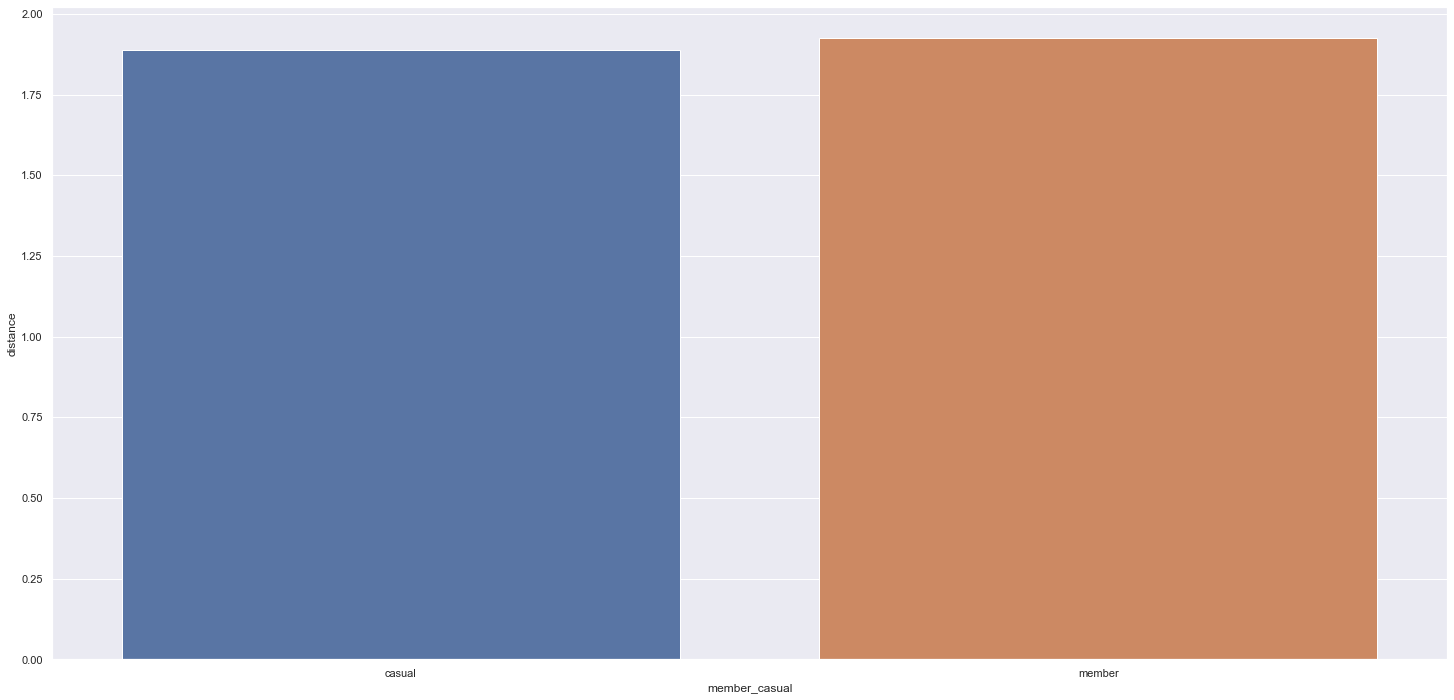

In [43]:
aux01 = df51[['distance', 'member_casual']].groupby( 'member_casual' ).mean().reset_index()
sns.barplot( x='member_casual',  y='distance',  data=aux01 )

#### H02. Casual users should use more on holidays.
**True** Casual users use more on holidays

<AxesSubplot:xlabel='holidays', ylabel='count'>

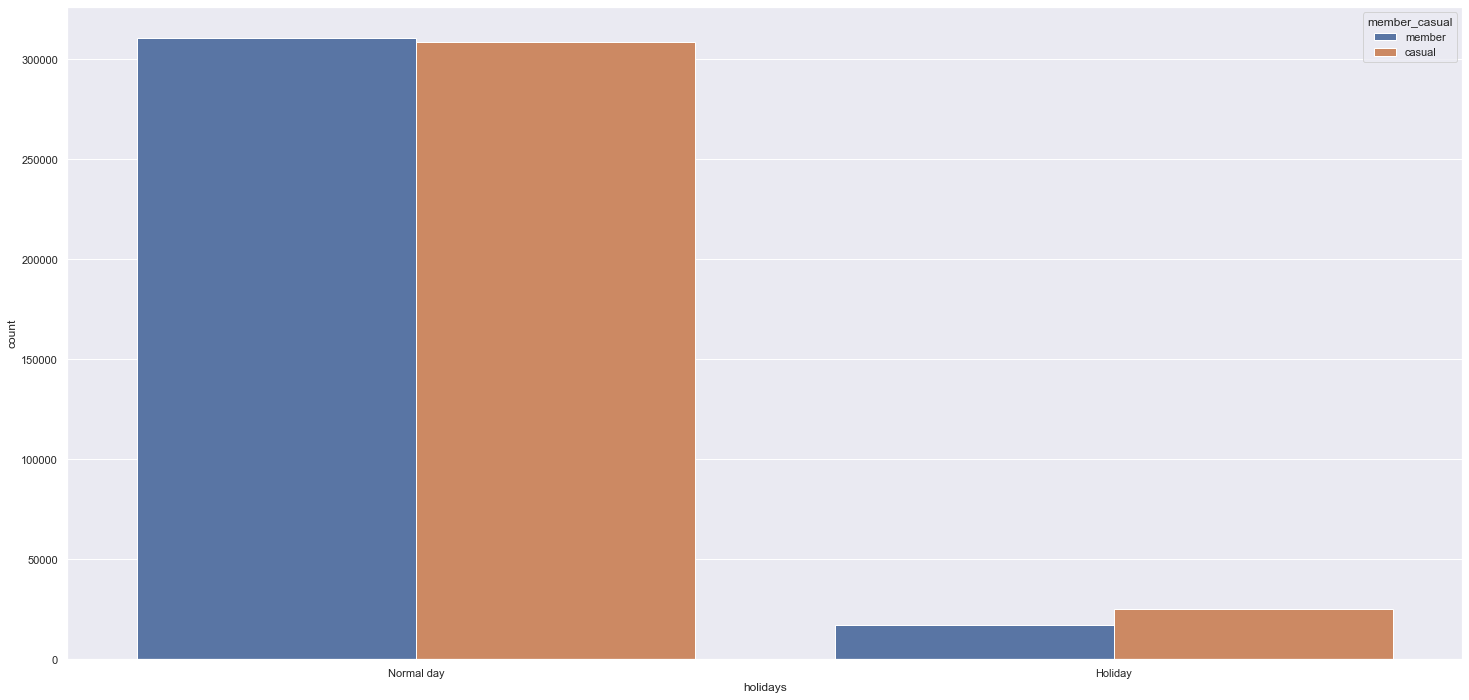

In [44]:
sns.countplot( x='holidays', data=df51, hue='member_casual' )

#### H03. Member users should use more on weekdays.
**True** Member users use more on weekdays.

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

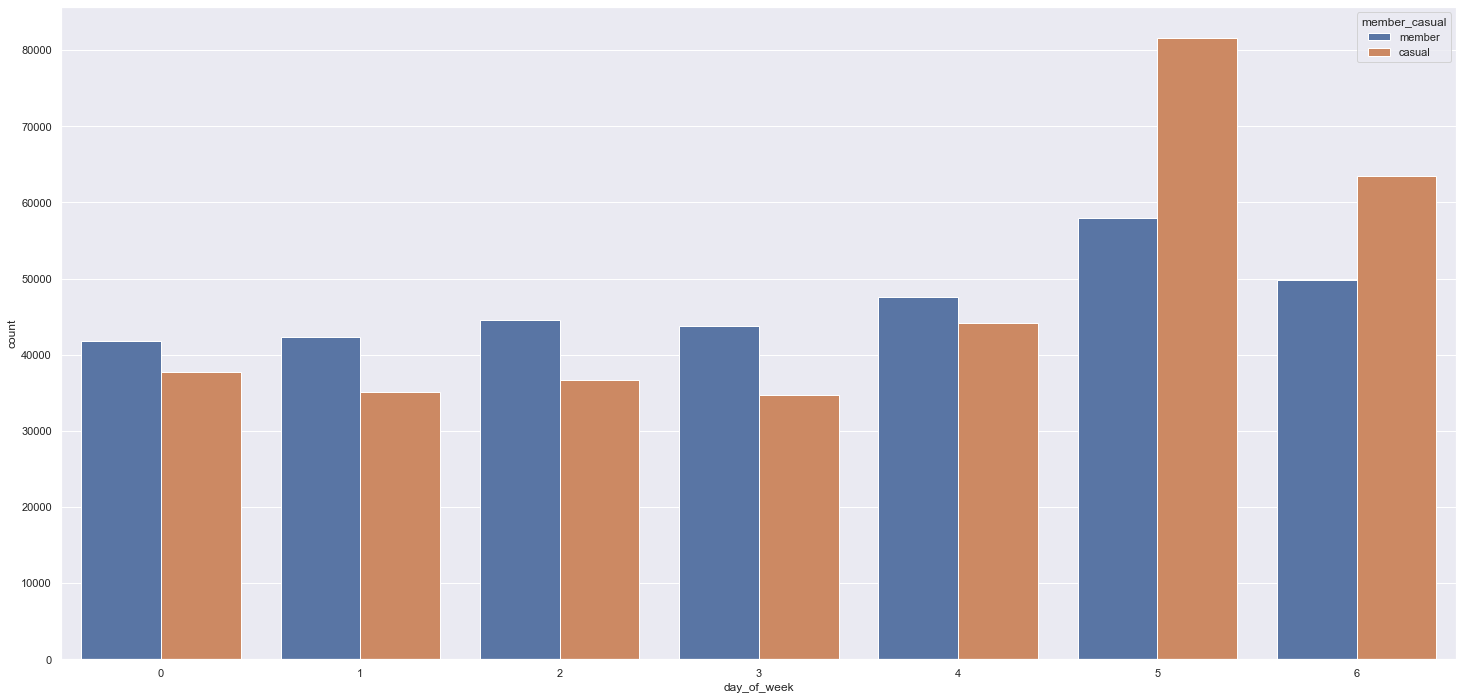

In [45]:
sns.countplot( x='day_of_week', data=df51, hue='member_casual' )

#### H04. Member users should use it consistently over the months.
**False** Member users don't use consistently over the months

<AxesSubplot:xlabel='month', ylabel='count'>

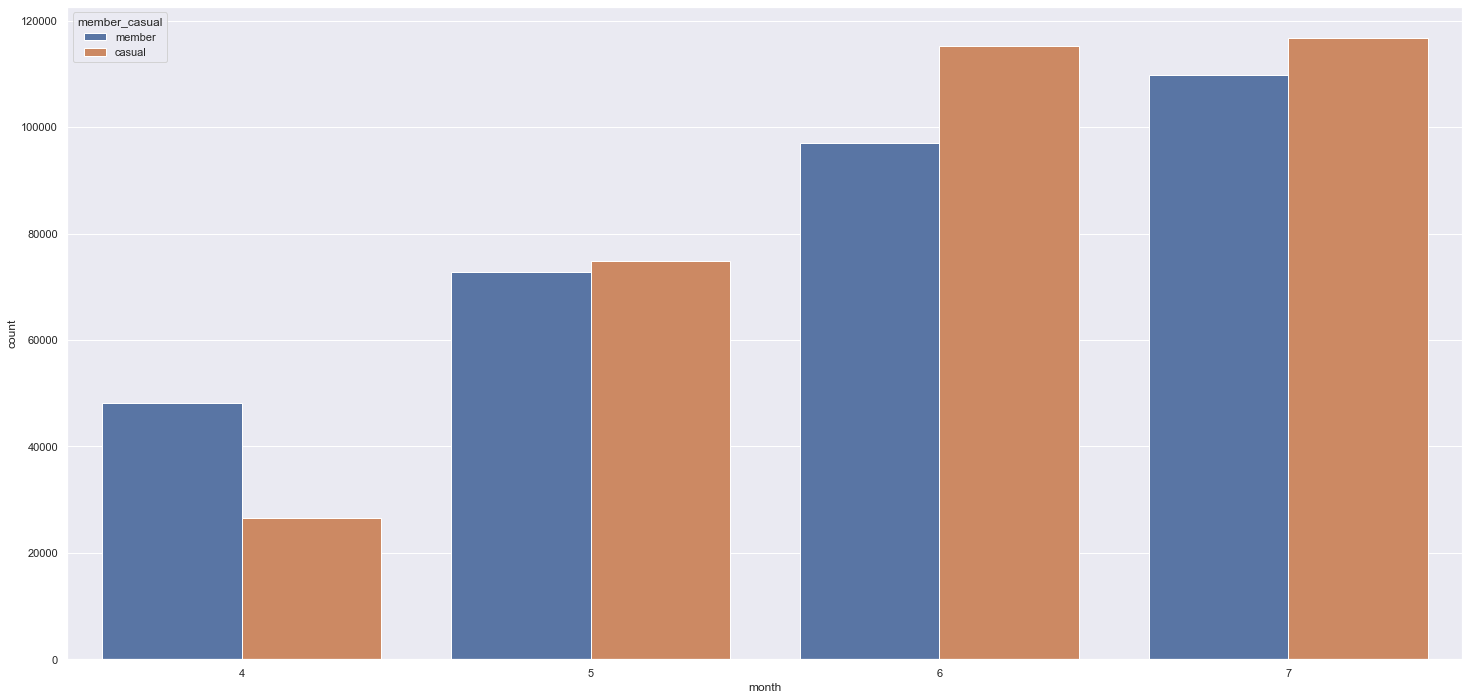

In [46]:
sns.countplot( x='month', data=df51, hue='member_casual' )

#### H05. Casual users should have longer travel times.
**True** Casual users have longer travel times.

<AxesSubplot:xlabel='member_casual', ylabel='duration'>

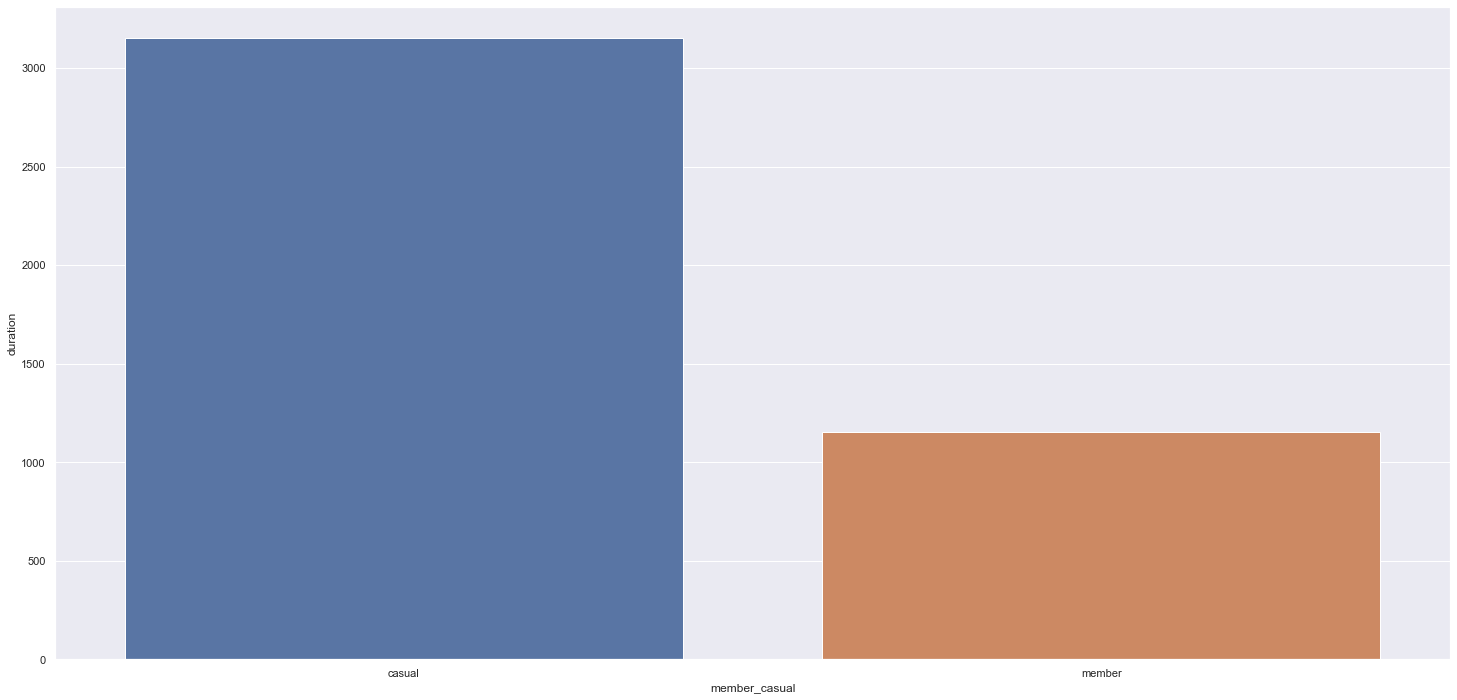

In [47]:
aux02 = df51[['duration', 'member_casual']].groupby( 'member_casual' ).mean().reset_index()
sns.barplot( x='member_casual',  y='duration',  data=aux02 )

#### H06. Member users should use more during daylight hours.
**True** Member users use more during daylight hours.

<AxesSubplot:xlabel='hour_of_day', ylabel='count'>

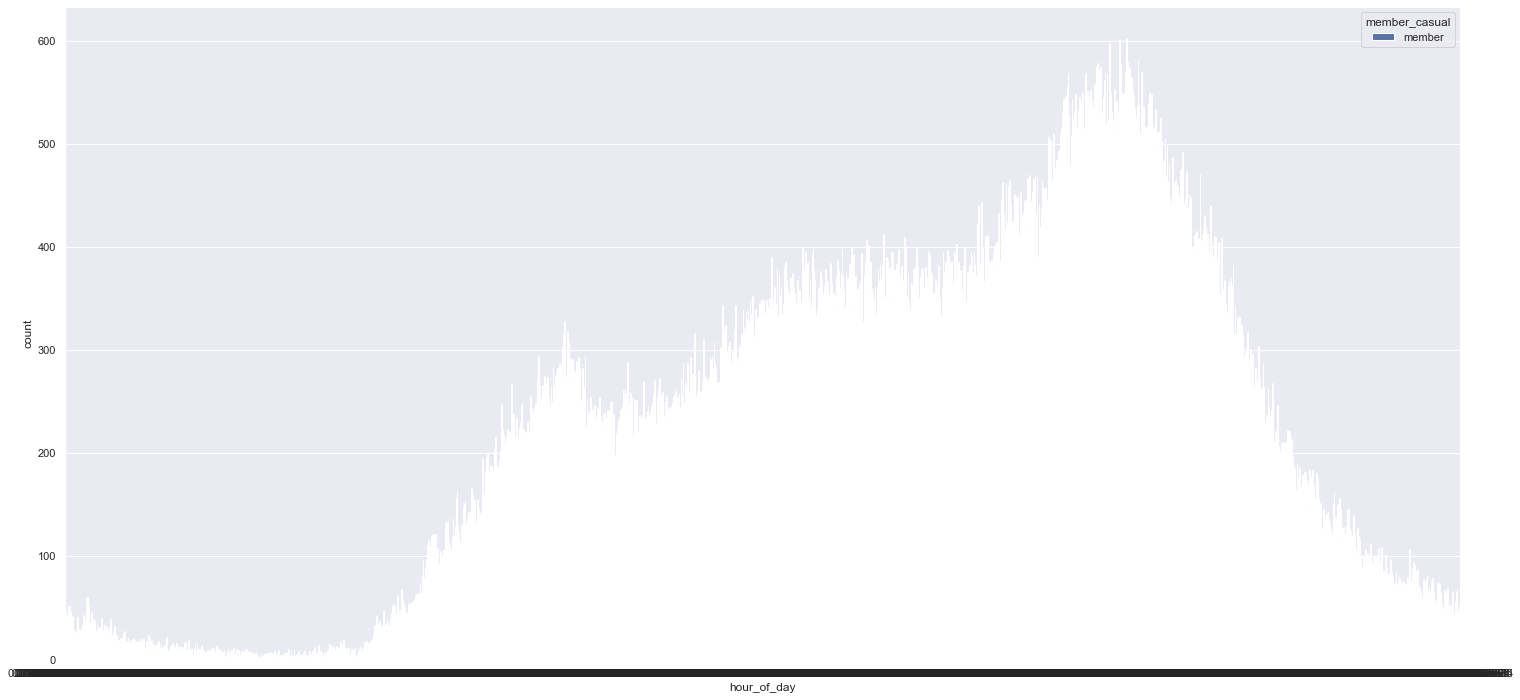

In [48]:
sns.countplot( x='hour_of_day', data=df51[df51['member_casual']=='member'], hue='member_casual' )

# As we can see, it's difficult to understand what's going on in this graph.
# I will separate the "hour_of_day" in bins values.

<AxesSubplot:xlabel='hour_of_day_binned', ylabel='count'>

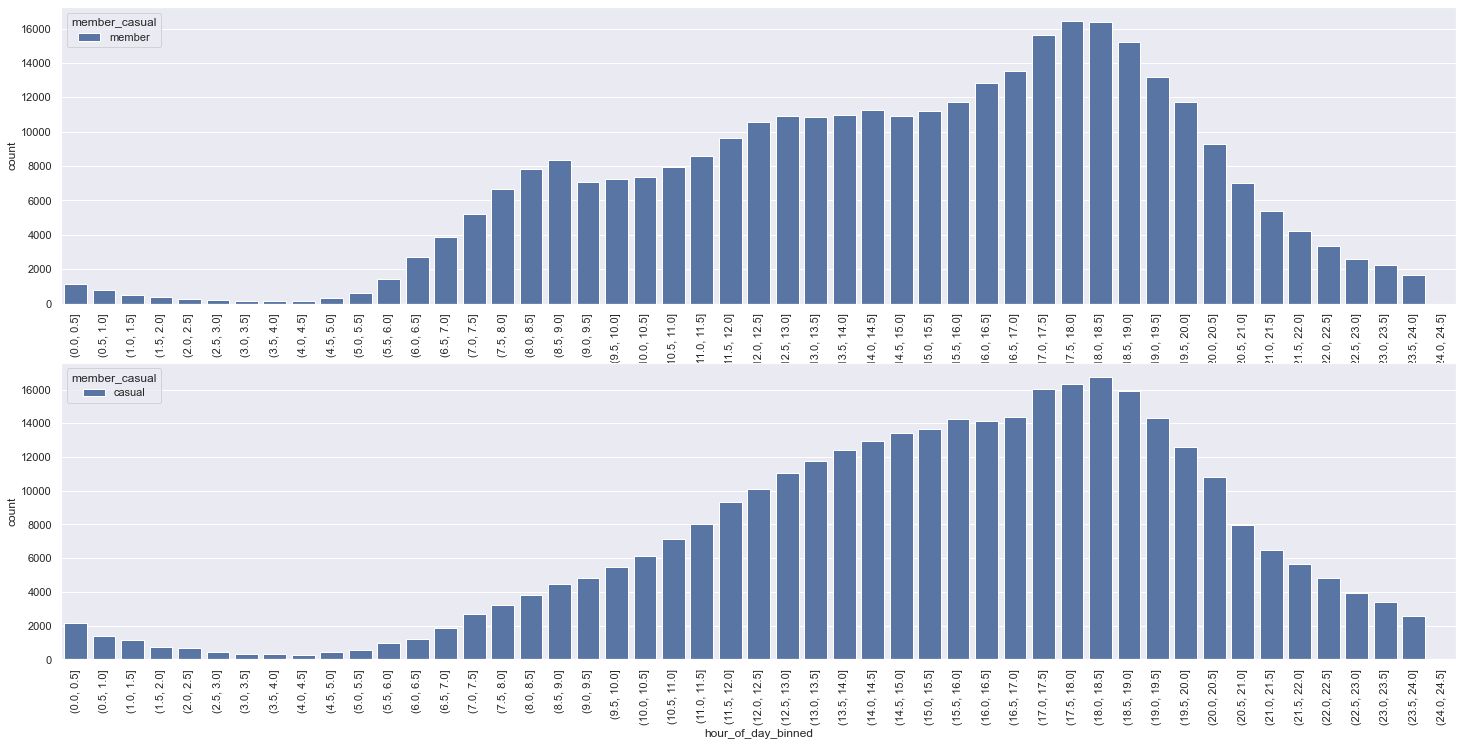

In [49]:
aux03 = df51.copy()

plt.subplot(2,1,1)
bins = list( np.arange(0, 25, 0.5) )
aux03['hour_of_day_binned'] = pd.cut( aux03['hour_of_day'], bins=bins )
plt.xticks( rotation=90)

sns.countplot( x='hour_of_day_binned', data=aux03[aux03['member_casual']=='member'], hue='member_casual' )

plt.subplot(2,1,2)
bins = list( np.arange(0, 25, 0.5) )
aux03['hour_of_day_binned'] = pd.cut( aux03['hour_of_day'], bins=bins )
plt.xticks( rotation=90)

sns.countplot( x='hour_of_day_binned', data=aux03[aux03['member_casual']=='casual'], hue='member_casual' )

#### <s> H07. The use of casual users must have increased over the years. <s>

<AxesSubplot:xlabel='year', ylabel='count'>

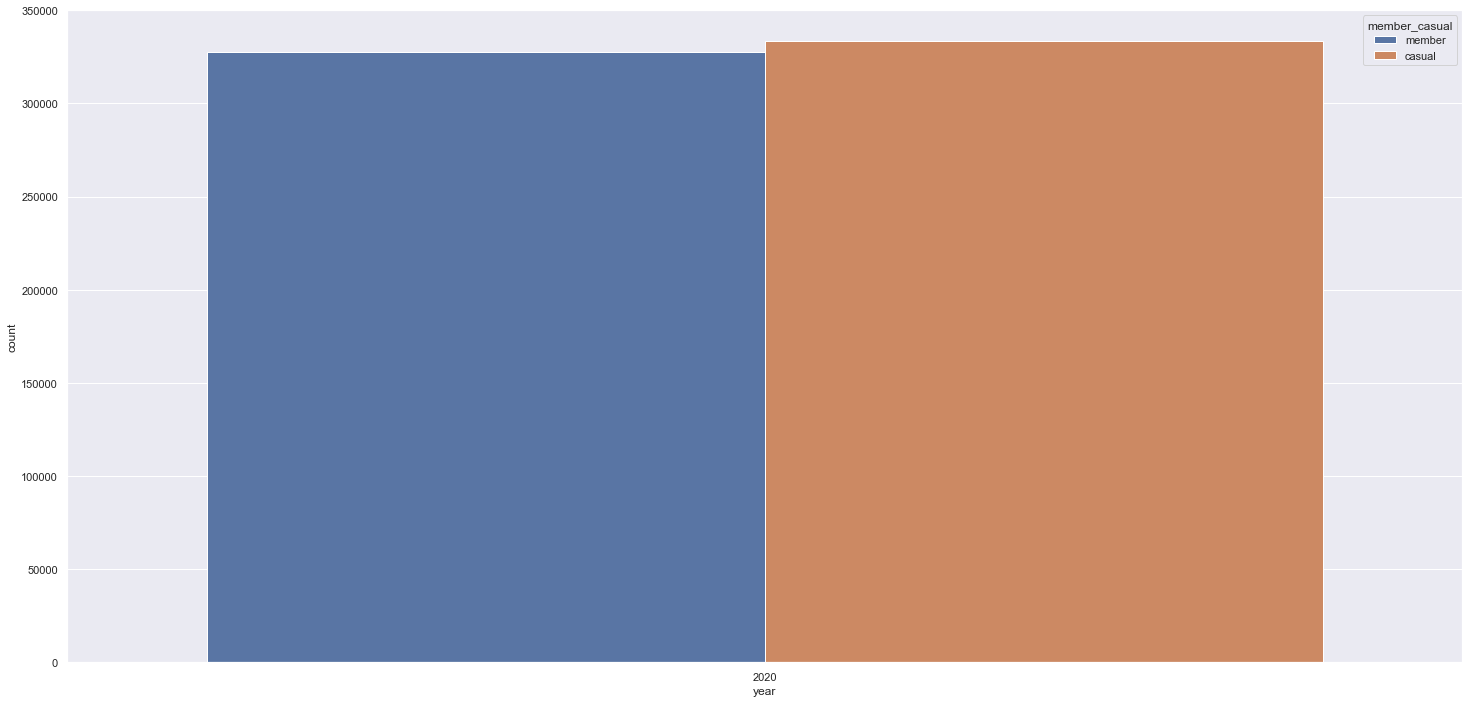

In [50]:
sns.countplot( x='year', data=df51, hue='member_casual' )
# I won't consider this Hyphotese because in this dataset we have only one year.

#### H08. Member users should use more in the early hours of the day and in the late afternoon.
**False** Member users don't use more in the early hours of the day and use more in late afternoon.

<AxesSubplot:xlabel='hour_of_day_binned', ylabel='count'>

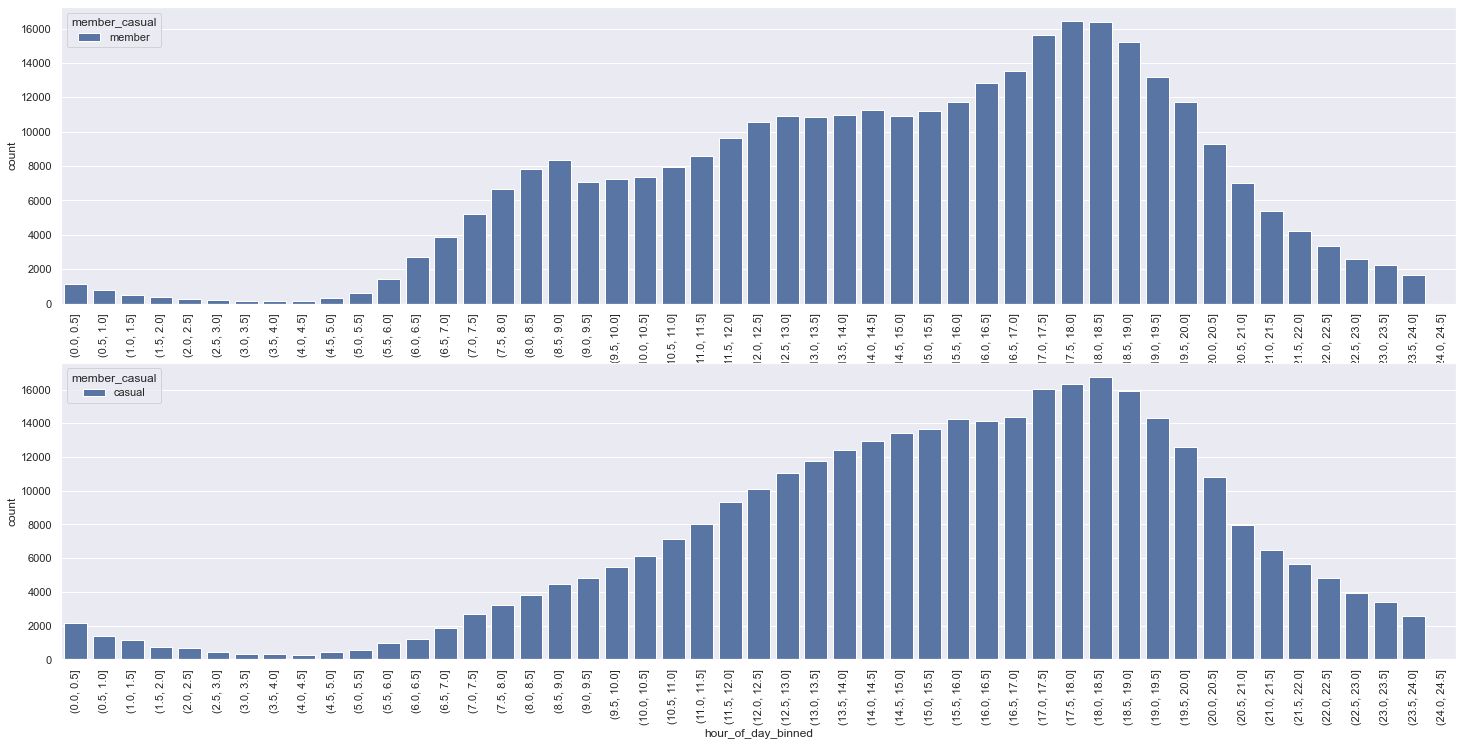

In [51]:
aux03 = df51.copy()

plt.subplot(2,1,1)
bins = list( np.arange(0, 25, 0.5) )
aux03['hour_of_day_binned'] = pd.cut( aux03['hour_of_day'], bins=bins )
plt.xticks( rotation=90)

sns.countplot( x='hour_of_day_binned', data=aux03[aux03['member_casual']=='member'], hue='member_casual' )

plt.subplot(2,1,2)
bins = list( np.arange(0, 25, 0.5) )
aux03['hour_of_day_binned'] = pd.cut( aux03['hour_of_day'], bins=bins )
plt.xticks( rotation=90)

sns.countplot( x='hour_of_day_binned', data=aux03[aux03['member_casual']=='casual'], hue='member_casual' )

#### H09. Casual users should use more in the summer seasons.
**True** Casual users use more in the summer seasons.

<AxesSubplot:xlabel='season', ylabel='count'>

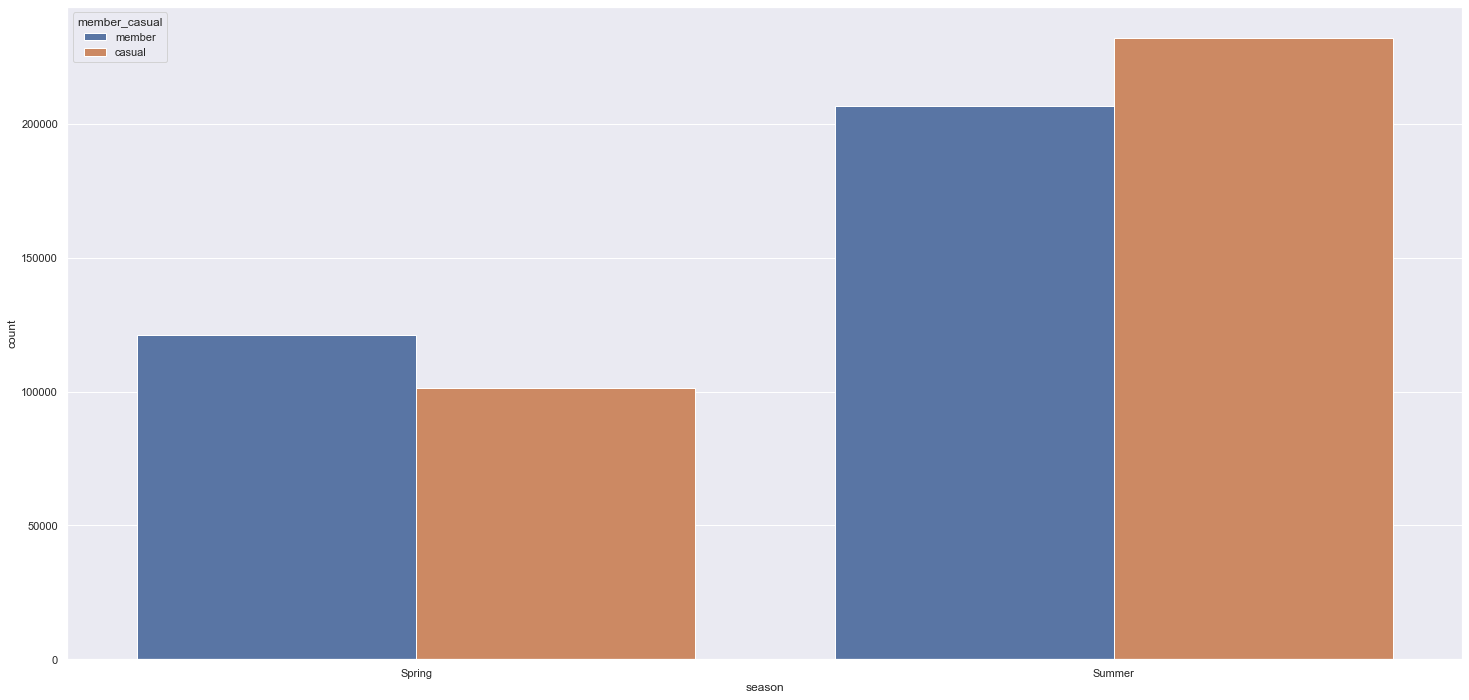

In [52]:
sns.countplot( x='season', data=df51, hue='member_casual' )

## 5.2 ML Model Understanding - Feature Correlation

In [53]:
df52 = df46.copy()

### 5.2.1 Univariable Analysis

In [54]:
prof = ProfileReport( df52 )
prof.to_notebook_iframe()

### 5.2.2 Bivariate Analysis

#### 5.2.2.1 Categorical X Categorical

**Rideable Type**

Correlation: 0.03963869269296311


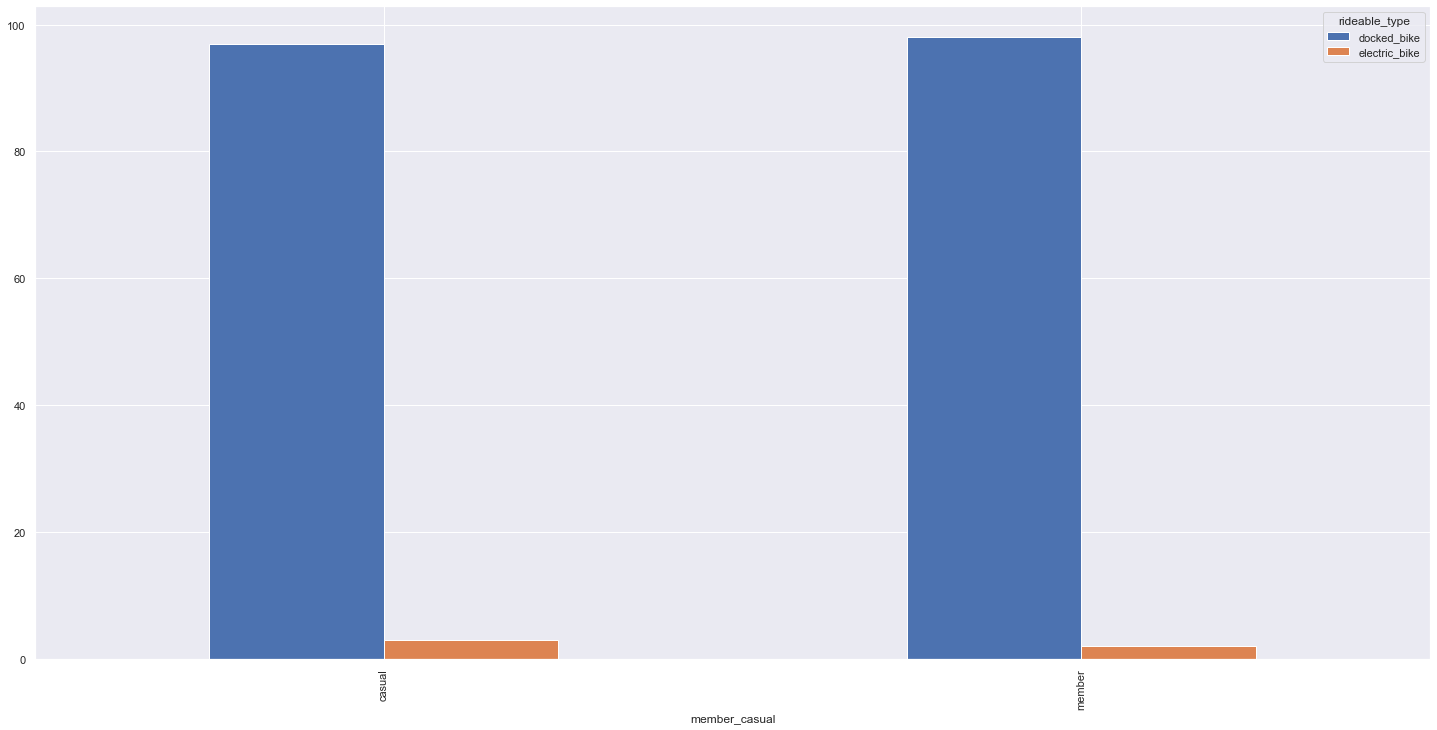

In [56]:
aux01 = pd.crosstab( df52['member_casual'], df52['rideable_type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar()

# Correlation: Cramer's V
r = cramer_v( df52['member_casual'], df52['rideable_type'] )
print( 'Correlation: {}'.format( r ) )

**Holidays**

Correlation: 0.05761549320235825


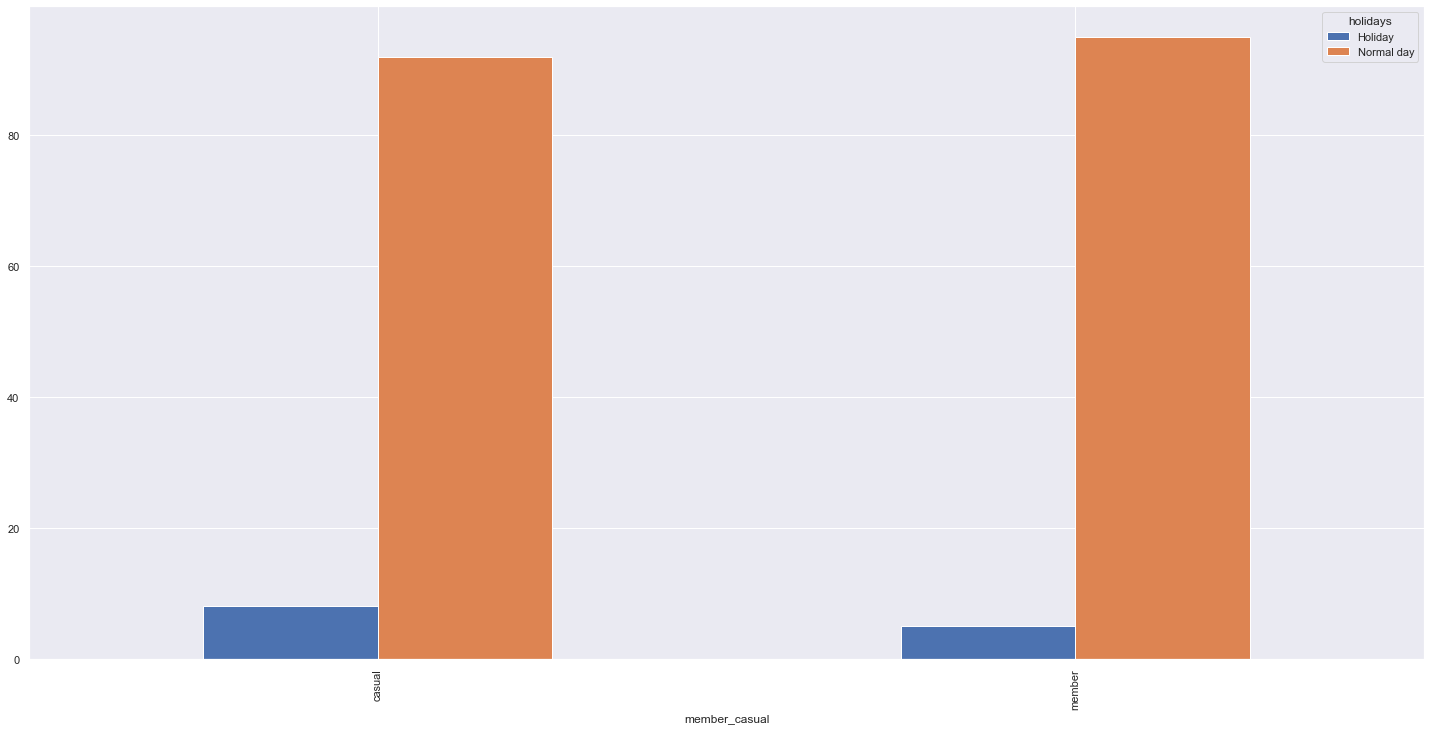

In [57]:
aux01 = pd.crosstab( df52['member_casual'], df52['holidays'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar()

# Correlation: Cramer's V
r = cramer_v( df52['member_casual'], df52['holidays'] )
print( 'Correlation: {}'.format( r ) )

**Season**

Correlation: 0.0859596904846789


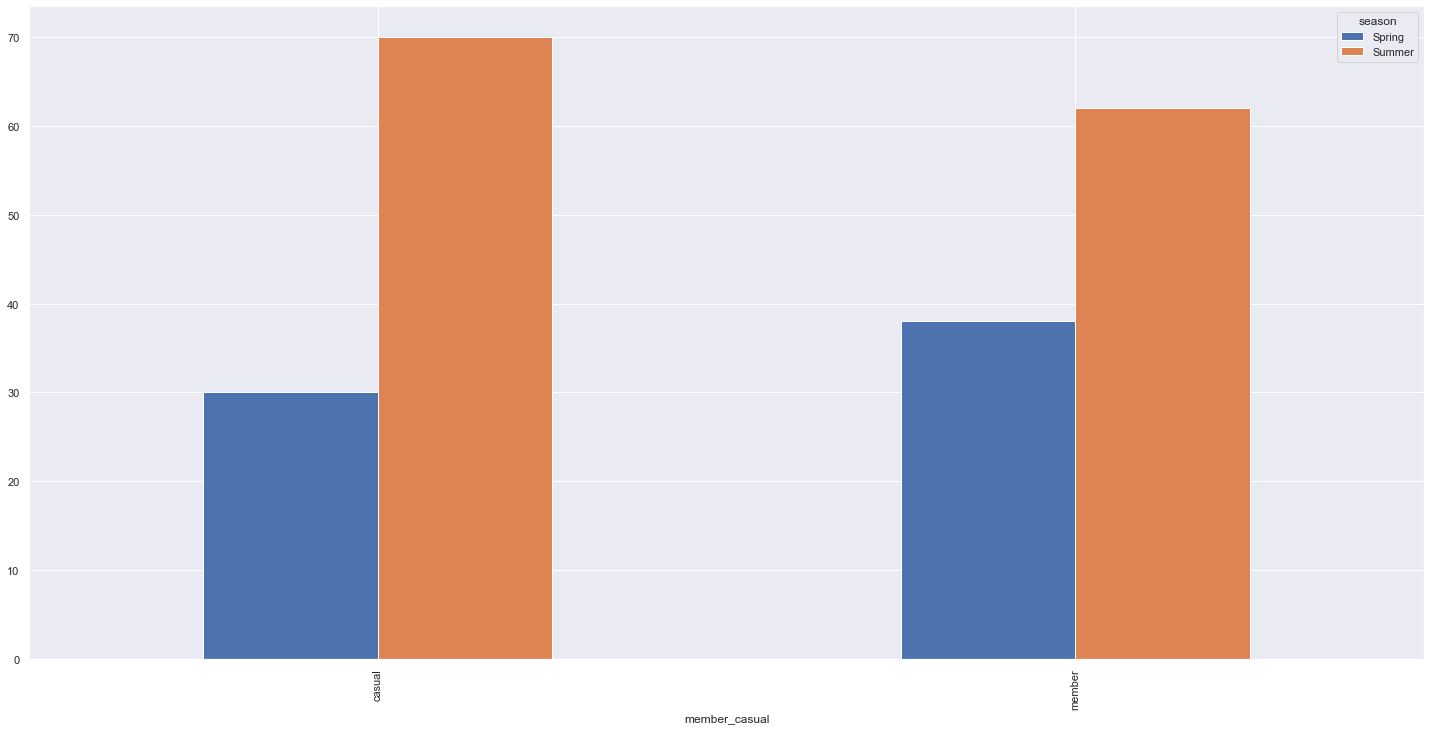

In [58]:
aux01 = pd.crosstab( df52['member_casual'], df52['season'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar()

# Correlation: Cramer's V
r = cramer_v( df52['member_casual'], df52['season'] )
print( 'Correlation: {}'.format( r ) )

### 5.2.3 Multivariate Analysis

<AxesSubplot:>

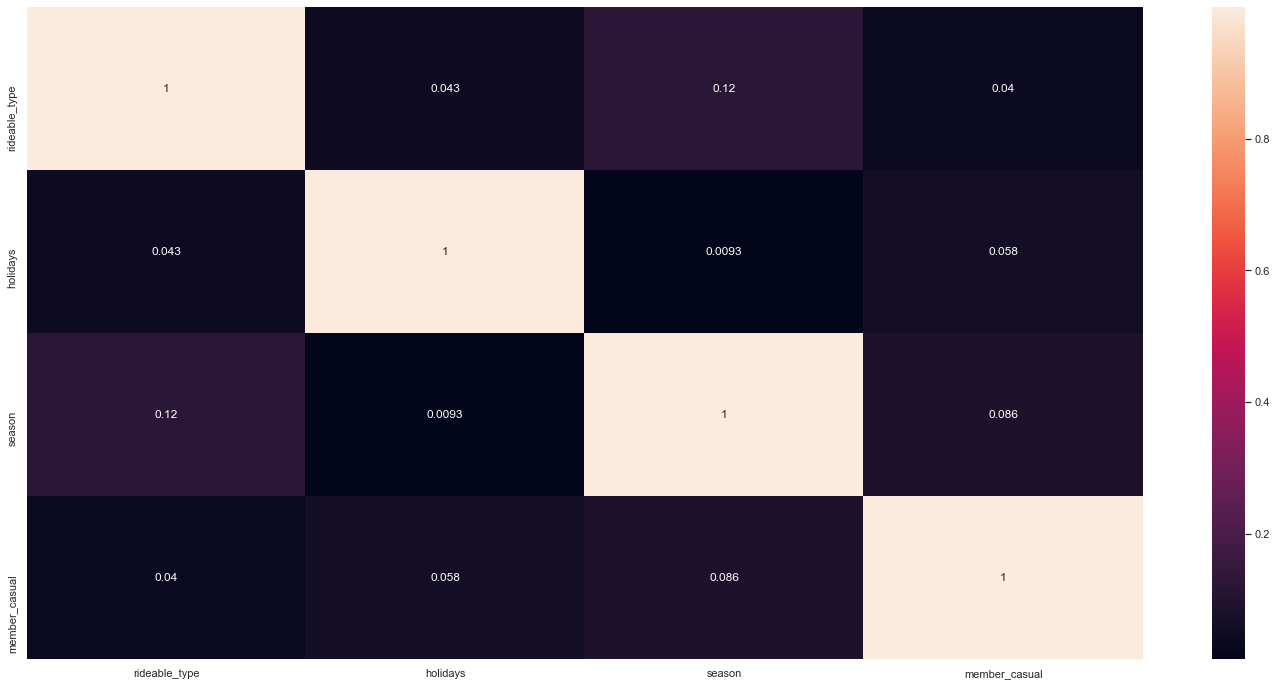

In [59]:
# list of categorical attributes
cat_attributes = df52.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
cat_attributes_list = cat_attributes.columns.tolist()
#cat_attributes_list = cat_attributes.drop( 'id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        #print( 'Ref: {} - Feat: {}'.format( cat_attributes_list[i], cat_attributes_list[j] ) )
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation between two categorical variables
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append to a list
        corr_list.append( corr )
        
    # append the correlation list for each ref attributes
    corr_dict[ref] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 6.0 - DATA PREPARATION

In [62]:
df6 = df46.copy()

df6.drop( 'year', axis=1, inplace=True )

## 6.1 Rescaling

<AxesSubplot:xlabel='duration'>

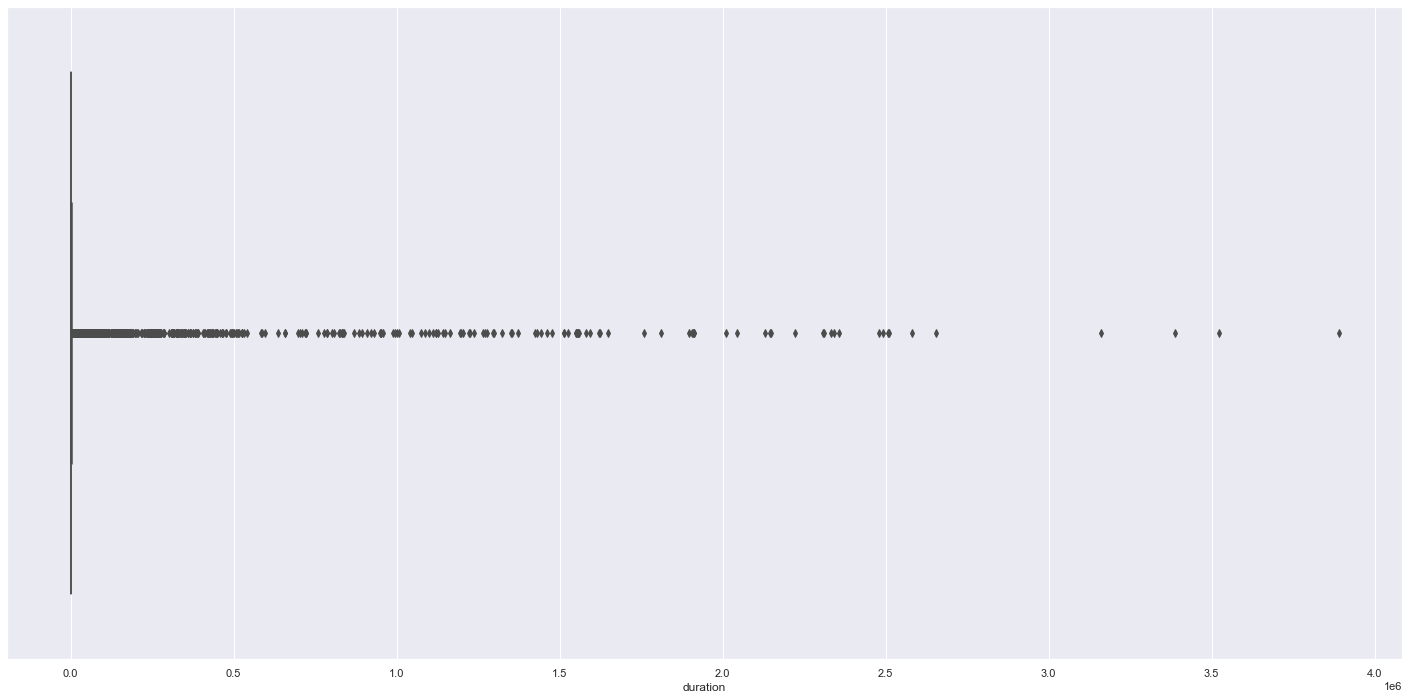

In [64]:
sns.boxplot( df6['duration'] )

<AxesSubplot:xlabel='distance'>

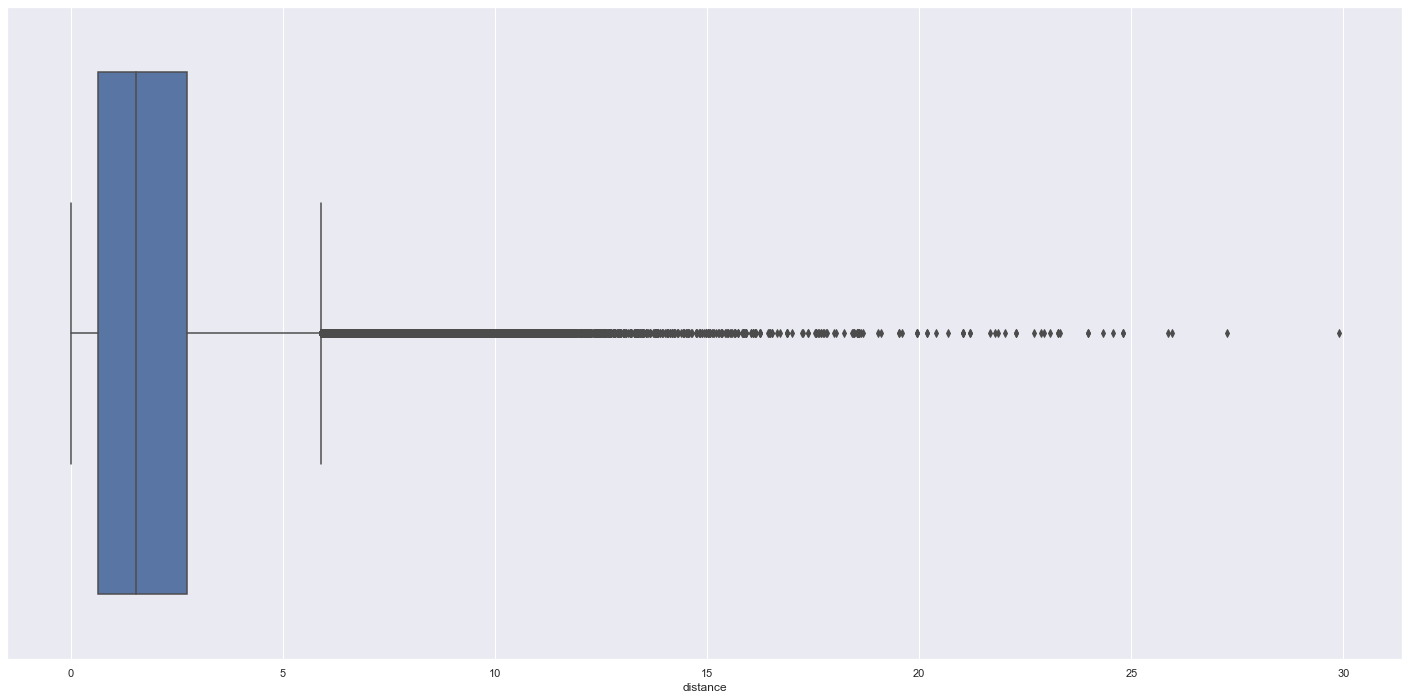

In [65]:
sns.boxplot( df6['distance'] )

In [66]:
rs = pp.RobustScaler()

# durantion
df6['duration'] = rs.fit_transform( df6[['duration']].values )

# distance
df6['distance'] = rs.fit_transform( df6[['distance']].values )

## 6.2 Encoding

In [74]:
# rideable_type
df6 = pd.get_dummies( df6, prefix=['rideable_type'], columns=['rideable_type'] )

# holidays
df6 = pd.get_dummies( df6, prefix=['holidays'], columns=['holidays'] )

## 6.3 Transformation

In [75]:
# month
df6['month_sin'] = df6['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/4 ) ) )
df6['month_cos'] = df6['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/4 ) ) )

# day
df6['day_sin'] = df6['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df6['day_cos'] = df6['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# hour_of_day
df6['hour_of_day_sin'] = df6['hour_of_day'].apply( lambda x: np.sin( x * ( 2. * np.pi/24 ) ) )
df6['hour_of_day_cos'] = df6['hour_of_day'].apply( lambda x: np.cos( x * ( 2. * np.pi/24 ) ) )

# season
season_dict = { 'Summer': 0, 'Spring': 1 }
df6['season'] = df6['season'].map( season_dict )
df6['season_sin'] = df6['season'].apply( lambda x: np.sin( x * ( 2. * np.pi/2 ) ) )
df6['season_cos'] = df6['season'].apply( lambda x: np.cos( x * ( 2. * np.pi/2 ) ) )

In [76]:
df6.sample()

,month,day,day_of_week,hour_of_day,duration,distance,season,member_casual,rideable_type_docked_bike,rideable_type_electric_bike,holidays_Holiday,holidays_Normal day,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,hour_of_day_sin,hour_of_day_cos,season_sin,season_cos
122828,5,2,5,12.566667,-0.232355,-0.239446,1,member,1,0,0,1,1.0,3.061617e-16,0.406737,0.913545,-0.974928,-0.222521,-0.147809,-0.989016,1.224647e-16,-1.0


In [77]:
cols_drop = ['month', 'day', 'day_of_week', 'hour_of_day', 'season']

df6 = df6.drop( cols_drop, axis=1 )

In [78]:
df6.sample(5).T

,100664,331047,436102,361081,2189
duration,-0.183188,2.16098,0.107851,-0.259318,0.718477
distance,-0.208815,-0.729148,1.04621,0.0786726,-0.729148
member_casual,casual,casual,member,casual,casual
rideable_type_docked_bike,1,1,1,1,1
rideable_type_electric_bike,0,0,0,0,0
holidays_Holiday,0,0,0,0,0
holidays_Normal day,1,1,1,1,1
month_sin,1,3.67394e-16,-1,-1,-2.44929e-16
month_cos,3.06162e-16,-1,-4.28626e-16,-4.28626e-16,1
day_sin,1.22465e-16,0.994522,-0.743145,0.866025,-0.743145


# 7.0 - FEATURE SELECTION

In [81]:
X = df6.drop( 'member_casual', axis=1 )
y = df6['member_casual'] 

# split traininset between train and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20, random_state=43, stratify=y )

## 7.1 Boruta as Feature Selection

In [86]:
# define Modelo Selector - ExtraTrees
etc = en.ExtraTreesClassifier( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( etc, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train.values, y_train.values.ravel() )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	12


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	12


## 7.2 Best Features from Boruta

In [87]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

# not selected by Boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train.columns, cols_selected_boruta ) )

In [88]:
cols_selected_boruta

['duration', 'distance', 'hour_of_day_sin', 'hour_of_day_cos']

In [89]:
cols_not_selected_boruta

['day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'day_sin',
 'holidays_Holiday',
 'holidays_Normal day',
 'month_cos',
 'month_sin',
 'rideable_type_docked_bike',
 'rideable_type_electric_bike',
 'season_cos',
 'season_sin']

## 7.3 Manual Feature Selection

In [90]:
cols_selected_boruta = [
    'duration',
    'distance',
    'hour_of_day_sin',
    'hour_of_day_cos']

# 8.0 - MACHINE LEARNING MODELING

In [91]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

**Now I will test some algorithms following in order of increasing in complexity, and in turn, capability. <br>
I'm not going to use everyone in each group, but at least one in each and see how they do and, depending on their characteristics, choose the best one to use as the final model in our project.**

**Naive Algorithms:** <br>
- Majority Class
- Minority Class
- Class Priors

**Linear Algorithms:** <br>
- Logistic Regression
- Linear Discriminant Analysis
- Naive Bayes

**Nonlinear Algorithms:** <br>
- Decision Tree
- k-Nearest Neighbors
- Artificial Neural Networks
- Support Vector Machine

**Ensemble Algorithms:** <br>
- Bagged Decision Trees
- Random Forest
- Extra Trees
- Stochastic Gradient Boosting

## 8.1 Baseline Model

In [92]:
import random

In [93]:
country_destination_list = y_test.drop_duplicates().sort_values().tolist()
random_num = x_test.shape[0]
country_destination_weights = df1['member_casual'].value_counts( normalize=True ).sort_index().tolist()

# prediction
yhat_random = random.choices( country_destination_list, k=random_num,
                              weights=country_destination_weights )

### 8.1.1 Baseline Model Performance

Accuracy: 0.5017827678419027
              precision    recall  f1-score   support

      casual      0.502     0.508     0.505     52727
      member      0.502     0.495     0.499     52727

    accuracy                          0.502    105454
   macro avg      0.502     0.502     0.502    105454
weighted avg      0.502     0.502     0.502    105454

Kappa Score: 0.003565535683805243


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

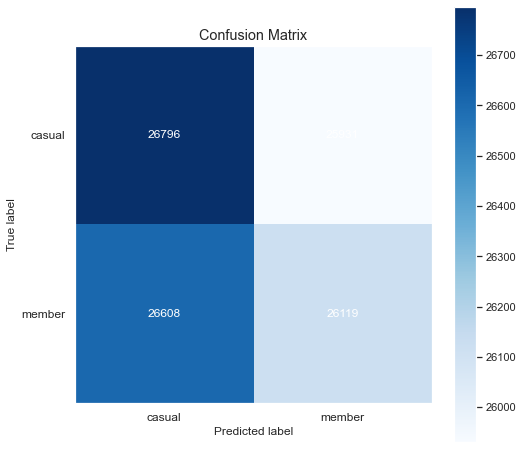

In [98]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Accuracy - Precision - Recall - F1 Score - Kappa Metrics - Confusion Matrix
print( m.classification_report( y_test, yhat_random, digits=3 ) )

# Kappa Metrics
print( 'Kappa Score: {}'.format( m.cohen_kappa_score( y_test, yhat_random ) ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=( 8, 8 ) )

## 8.2 Model: Logistic Regression

In [101]:
# model definition
model_lg = lm.LogisticRegression( n_jobs=-1, random_state=32 )

# train model
model_lg.fit( x_train, y_train )

LogisticRegression(n_jobs=-1, random_state=32)

### 8.2.1 Logistic Regression Performance

In [102]:
# prediction
yhat = model_lg.predict( x_test )

              precision    recall  f1-score   support

      casual      0.799     0.566     0.663     52727
      member      0.664     0.858     0.748     52727

    accuracy                          0.712    105454
   macro avg      0.732     0.712     0.706    105454
weighted avg      0.732     0.712     0.706    105454

Accuracy: 0.7118648889563222
Weighted F1-Score: 0.7056185829807223
Balanced Accuracy Score: 0.7118648889563222
Kappa Score: 0.4237297779126443


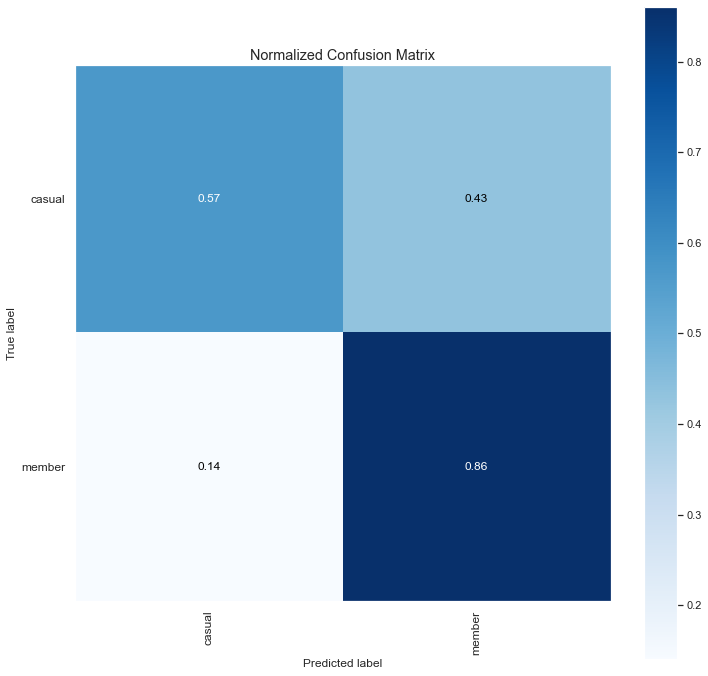

In [103]:
# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat, normalize=True, figsize=( 12, 12 ) )
plt.xticks(rotation ='vertical')

# Accuracy - Precision - Recall - F1 Score - Kappa Metrics - Confusion Matrix
print( m.classification_report( y_test, yhat, digits=3 ) )

# =========== Balanced Dataframe Metrics =============
# Accuracy
acc = m.accuracy_score( y_test, yhat )
print( 'Accuracy: {}'.format( acc ) )

# =========== Unbalanced Dataframe Metrics =============
# Weighted F1-Score
f1_score = m.f1_score( y_test, yhat, average='weighted' )
print( 'Weighted F1-Score: {}'.format( f1_score ) )

# Balanced Accuracy Score
balanced_acc = m.balanced_accuracy_score( y_test, yhat )
print( 'Balanced Accuracy Score: {}'.format( balanced_acc ) )

# Kappa Metrics
print( 'Kappa Score: {}'.format( m.cohen_kappa_score( y_test, yhat ) ) )

### 8.2.2 Logistic Regression Performance - Cross Validation

In [104]:
# geneate K-Fold
num_fold = 5
kfold = ms.StratifiedKFold( n_splits=num_fold, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_list = []
weighted_f1_score_list = []
i = 1

for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_fold ) )
    
    # get fold data -
    x_train_fold = x_train.iloc[train_ix]
    x_val_fold = x_train.iloc[val_ix]
    
    y_train_fold = y_train.iloc[train_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # model definition
    model = lm.LogisticRegression( n_jobs=-1, random_state=32 )

    # train model
    model.fit( x_train_fold, y_train_fold )

    # prediction
    yhat_fold = model.predict( x_val_fold )

    # Balanced Accuracy
    balanced_acc = m.balanced_accuracy_score( y_val_fold, yhat_fold )
    balanced_acc_list.append( balanced_acc )

    # Kappa Metrics
    kappa = m.cohen_kappa_score( y_val_fold, yhat_fold )
    kappa_list.append( kappa )
    
    # Weighted F1-Score
    weighted_f1_score = m.f1_score( y_val_fold, yhat_fold, average='weighted')
    weighted_f1_score_list.append( weighted_f1_score )
    
    i += 1
    
print( 'Avg Balanced Accuracy: {}'.format( np.mean( balanced_acc_list ) ) )
print( 'Avg Weighted F1-Score: {}'.format( np.mean( weighted_f1_score_list ) ) )
print( 'Avg Kappa: {}'.format( np.mean( kappa_list ) ) )

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5
Avg Balanced Accuracy: 0.713863043853188
Avg Weighted F1-Score: 0.7078159582928911
Avg Kappa: 0.4277260903741372


## 8.3 Model: K-Nearest Neighbour

In [105]:
# model definition
model_knn = nb.KNeighborsClassifier( n_neighbors=2, n_jobs=-1 )

# train model
model_knn.fit( x_train, y_train )

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

### 8.3.1 KNN Performance

In [106]:
# prediction
yhat = model_knn.predict( x_test )

              precision    recall  f1-score   support

      casual      0.614     0.825     0.704     52727
      member      0.733     0.481     0.581     52727

    accuracy                          0.653    105454
   macro avg      0.673     0.653     0.642    105454
weighted avg      0.673     0.653     0.642    105454

Accuracy: 0.6528723424431506
Weighted F1-Score: 0.6422875459950211
Balanced Accuracy Score: 0.6528723424431505
Kappa Score: 0.30574468488630113


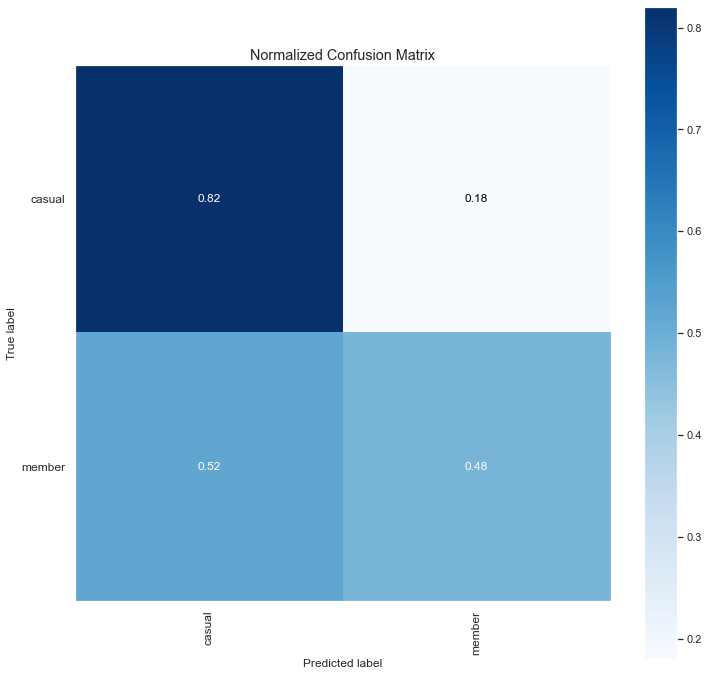

In [107]:
# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat, normalize=True, figsize=( 12, 12 ) )
plt.xticks(rotation ='vertical')

# Accuracy - Precision - Recall - F1 Score - Kappa Metrics - Confusion Matrix
print( m.classification_report( y_test, yhat, digits=3 ) )

# =========== Balanced Dataframe Metrics =============
# Accuracy
acc = m.accuracy_score( y_test, yhat )
print( 'Accuracy: {}'.format( acc ) )

# =========== Unbalanced Dataframe Metrics =============
# Weighted F1-Score
f1_score = m.f1_score( y_test, yhat, average='weighted' )
print( 'Weighted F1-Score: {}'.format( f1_score ) )

# Balanced Accuracy Score
balanced_acc = m.balanced_accuracy_score( y_test, yhat )
print( 'Balanced Accuracy Score: {}'.format( balanced_acc ) )

# Kappa Metrics
print( 'Kappa Score: {}'.format( m.cohen_kappa_score( y_test, yhat ) ) )

### 8.3.2 KNN Fine-Tuning

In [110]:
balanced_acc_list = []
for i in range( 1, 15 ):
    print( 'K-value: {}'.format( i ) )
    # model definition
    model_knn = nb.KNeighborsClassifier( n_neighbors=i, n_jobs=-1 )

    # train model
    model_knn.fit( x_train, y_train )
    
    # prediction
    yhat = model_knn.predict( x_test )
    
    # Balanced Accuracy Score
    balanced_acc_list.append( m.balanced_accuracy_score( y_test, yhat ) )

K-value: 1
K-value: 2
K-value: 3
K-value: 4
K-value: 5
K-value: 6
K-value: 7
K-value: 8
K-value: 9
K-value: 10
K-value: 11
K-value: 12
K-value: 13
K-value: 14


Text(0, 0.5, 'Balanced Accuracy')

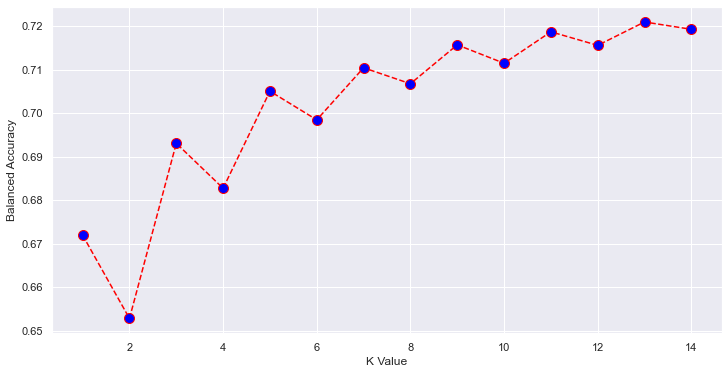

In [111]:
plt.figure( figsize=(12, 6) )
plt.plot( range( 1, 15 ), balanced_acc_list, color='red', linestyle='dashed', marker='o',
                                             markerfacecolor='blue', markersize=10 )
plt.xlabel( 'K Value' )
plt.ylabel( 'Balanced Accuracy' )

## 8.4 Model: Support Vector Machine

In [112]:
# model definition
model_svm = svm.SVC(random_state=32)

# model training
model_svm.fit( x_train, y_train )

SVC(random_state=32)

### 8.4.1 SVM Performance

In [113]:
# prediction
yhat = model_svm.predict( x_test )

              precision    recall  f1-score   support

      casual      0.813     0.562     0.664     52727
      member      0.665     0.871     0.754     52727

    accuracy                          0.716    105454
   macro avg      0.739     0.716     0.709    105454
weighted avg      0.739     0.716     0.709    105454

Accuracy: 0.7161131867923455
Weighted F1-Score: 0.7091707148144979
Balanced Accuracy Score: 0.7161131867923455
Kappa Score: 0.43222637358469096


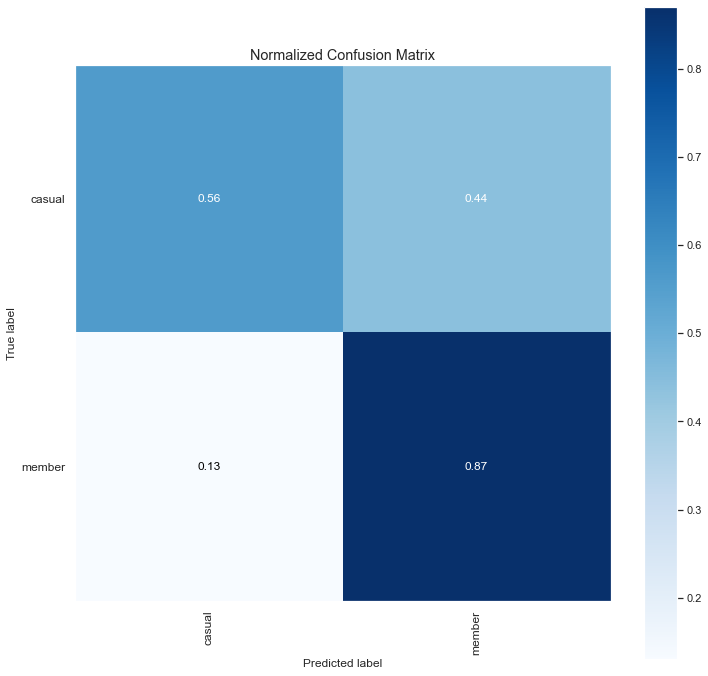

In [114]:
# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat, normalize=True, figsize=( 12, 12 ) )
plt.xticks(rotation ='vertical')

# Accuracy - Precision - Recall - F1 Score - Kappa Metrics - Confusion Matrix
print( m.classification_report( y_test, yhat, digits=3 ) )

# =========== Balanced Dataframe Metrics =============
# Accuracy
acc = m.accuracy_score( y_test, yhat )
print( 'Accuracy: {}'.format( acc ) )

# =========== Unbalanced Dataframe Metrics =============
# Weighted F1-Score
f1_score = m.f1_score( y_test, yhat, average='weighted' )
print( 'Weighted F1-Score: {}'.format( f1_score ) )

# Balanced Accuracy Score
balanced_acc = m.balanced_accuracy_score( y_test, yhat )
print( 'Balanced Accuracy Score: {}'.format( balanced_acc ) )

# Kappa Metrics
print( 'Kappa Score: {}'.format( m.cohen_kappa_score( y_test, yhat ) ) )

### 8.4.2 SVM Performance - Cross Validation

In [ ]:
# geneate K-Fold
num_fold = 5
kfold = ms.StratifiedKFold( n_splits=num_fold, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_list = []
weighted_f1_score_list = []
i = 1

for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_fold ) )
    
    # get fold data -
    x_train_fold = x_train.iloc[train_ix]
    x_val_fold = x_train.iloc[val_ix]
    
    y_train_fold = y_train.iloc[train_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # model definition
    model = svm.SVC( random_state=32 )

    # train model
    model.fit( x_train_fold, y_train_fold )

    # prediction
    yhat_fold = model.predict( x_val_fold )

    # Balanced Accuracy
    balanced_acc = m.balanced_accuracy_score( y_val_fold, yhat_fold )
    balanced_acc_list.append( balanced_acc )

    # Kappa Metrics
    kappa = m.cohen_kappa_score( y_val_fold, yhat_fold )
    kappa_list.append( kappa )
    
    # Weighted F1-Score
    weighted_f1_score = m.f1_score( y_val_fold, yhat_fold, average='weighted')
    weighted_f1_score_list.append( weighted_f1_score )
    
    i += 1
    
print( 'Avg Balanced Accuracy: {}'.format( np.mean( balanced_acc_list ) ) )
print( 'Avg Weighted F1-Score: {}'.format( np.mean( weighted_f1_score_list ) ) )
print( 'Avg Kappa: {}'.format( np.mean( kappa_list ) ) )

Fold Number: 1/5
